# DM modeling of Terzan 5 pulsars

This notebook analyzes DM variations in the timing of five of the brightests pulsars in the Terzan 5 globular cluster using PINT. It fits DMX parameters, estimates a common DM ammong these pulsas, applies a Gaussian Process regression, and visualizes the residuals.

### Goals:
The main goal is to compare two different DM models: DMX applied separately to each pulsar vs a common DM model + Gaussian Process (GP) fitting. The comparison is performed using the Akaike Information Criterion (AIC).

## DMX for all pulsars separately
We first obtain the DMX model for each of the pulsars 'manually', we use pulsar Ter5 M as a test case.

In [1]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt

import pint.logging
import pint.models.timing_model
from pint.models import get_model_and_toas
from pint.models import dispersion_model
from pint.models import parameter as p
from pint import residuals, fitter, toa, utils 

pint.logging.setup(level="INFO")

%matplotlib widget

In [2]:
# Load the model and TOAs

m1: pint.models.timing_model.TimingModel
t1: pint.toa.TOAs
m1, t1 = get_model_and_toas('1748-2446M.par', 'new_Ter5M.tim', usepickle=True)

mjds = t1.get_mjds().value
mjd_min, mjd_max = np.min(mjds), np.max(mjds)

INFO     (pint.models.parameter         ): Parameter PBDOT's value will be scaled by 1e-12
INFO     (pint.models.parameter         ): Parameter PBDOT's value will be scaled by 1e-12
INFO     (pint.toa                      ): Reading TOAs from the picklefile for `new_Ter5M.tim`


In [3]:
# Create DMX bins

bin_width = 50  # days                                                                                                                          
start_mjds = np.arange(mjd_min, mjd_max, bin_width)
end_mjds = np.minimum(start_mjds + bin_width, mjd_max)

# Keep only bins that have TOAs  

valid_starts, valid_ends = [], []
for start, end in zip(start_mjds, end_mjds):
    if np.any((mjds >= start) & (mjds < end)):
        valid_starts.append(start)
        valid_ends.append(end)

valid_starts = np.array(valid_starts)
valid_ends = np.array(valid_ends)

# Clean existing DMX and add a new DMX model

for param in list(m1.params):
    if param.startswith("DMX"):
    	m1.remove_param(param)

dmx_model = dispersion_model.DispersionDMX() 
dmx_model.DMXR1_0001.value = valid_starts[0] 
dmx_model.DMXR2_0001.value = valid_ends[0]
dmx_model.add_DMX_ranges(
    mjd_starts=valid_starts[1:], mjd_ends=valid_ends[1:], dmxs=0, frozens=False
)
m1.add_component(dmx_model)

In [4]:
#Fit model and compute residuals
fitter = pint.fitter.WLSFitter(t1, m1)
fitter.fit_toas(maxiter=1)
fitter.print_summary()

r1 = pint.residuals.Residuals(t1, m1)
dm_resid = (r1.calc_time_resids().value * t1.table["freq"].data**2) / 4.15e3
dm_resid_err = (t1.table["error"].value * 1e-6 * t1.table["freq"].data**2) / 4.15e3

INFO     (pint.observatory              ): Applying GPS to UTC clock correction (~few nanoseconds)
INFO     (pint.observatory              ): Loading global GPS clock file
INFO     (pint.observatory              ): Using global clock file for gps2utc.clk with bogus_last_correction=False
INFO     (pint.observatory              ): Applying TT(TAI) to TT(BIPM2021) clock correction (~27 us)
INFO     (pint.observatory              ): Loading BIPM clock version bipm2021
INFO     (pint.observatory              ): Using global clock file for tai2tt_bipm2021.clk with bogus_last_correction=False
INFO     (pint.observatory              ): Using global clock file for time_gbt.dat with bogus_last_correction=False
INFO     (pint.observatory.topo_obs     ): Applying observatory clock corrections for observatory='gbt'.
INFO     (pint.solar_system_ephemerides ): Set solar system ephemeris to de440 through astropy
WARNING  (pint.logging                  ): /home/uwm/vleescho/Data15/vleescho/conda/envs/I

Fitted model using weighted_least_square method with 93 free parameters to 568 TOAs
Prefit residuals Wrms = 11.101207212636456 us, Postfit residuals Wrms = 8.295343754131299 us
Chisq = 863.109 for 474 d.o.f. for reduced Chisq of 1.821

PAR                        Prefit                  Postfit            Units
=================== ==================== ============================ =====
PSR                           1748-2446M 1748-2446M                   None
EPHEM                              DE440 DE440                        None
CLOCK                       TT(BIPM2019) TT(BIPM2019)                 None
UNITS                                TDB TDB                          None
START                              51884                      51884.1 d 
FINISH                           59565.9                      59362.3 d 
TIMEEPH                             FB90 FB90                         None
T2CMETHOD                       IAU2000B IAU2000B                     None
BINARY          

In [5]:
# Bin statistics

dmx = pint.utils.dmxparse(fitter)
dmxr1s = dmx["r1s"] #starting mjds of dmx bins
dmxr2s = dmx["r2s"] #ending mjds of dmx bins
dmx_values = dmx["dmxs"].value 
#dmx_stats = pint.utils.dmxstats(f.model, f.toas)

dm_resid_perbin = []
dm_resid_err_perbin = []
weighted_means = []
weighted_errs = []

for r1, r2 in zip(dmxr1s, dmxr2s):
    mask = (t1.table["mjd_float"] >= r1) & (t1.table["mjd_float"] <= r2)
    resid_bin = dm_resid[mask] #DM resid per DMX bin
    err_bin = dm_resid_err[mask] #DM resid erros per DMX bin
    dm_resid_perbin.append(resid_bin)
    dm_resid_err_perbin.append(err_bin)

    if len(resid_bin) > 0:
        weights = 1.0 / err_bin**2
        mean = np.sum(weights * resid_bin) / np.sum(weights)
        err = np.sqrt(1.0 / np.sum(weights))
        weighted_errs.append(err)
        weighted_means.append(mean)

weighted_means = np.array(weighted_means) 
weighted_errs = np.array(weighted_errs)

# Correct DM residuals, so obtain the DM residuals - corresponding DMX bin k.

dm_resid_corrected_perbin = [
    resid - dmx_values[i] if len(resid) > 0 else np.array([]) #DM residuals - DMX
    for i, resid in enumerate(dm_resid_perbin)
]

dm_resid_corrected_flat = np.concatenate(dm_resid_corrected_perbin)
dm_resid_err_flat = np.concatenate(dm_resid_err_perbin)

# Calculate the chi2 value

chi2 = np.sum((dm_resid_corrected_flat)**2 / dm_resid_err_flat**2)
dof = len(dm_resid_corrected_flat) - len(dmx_values)
reduced_chi2 = chi2 / dof

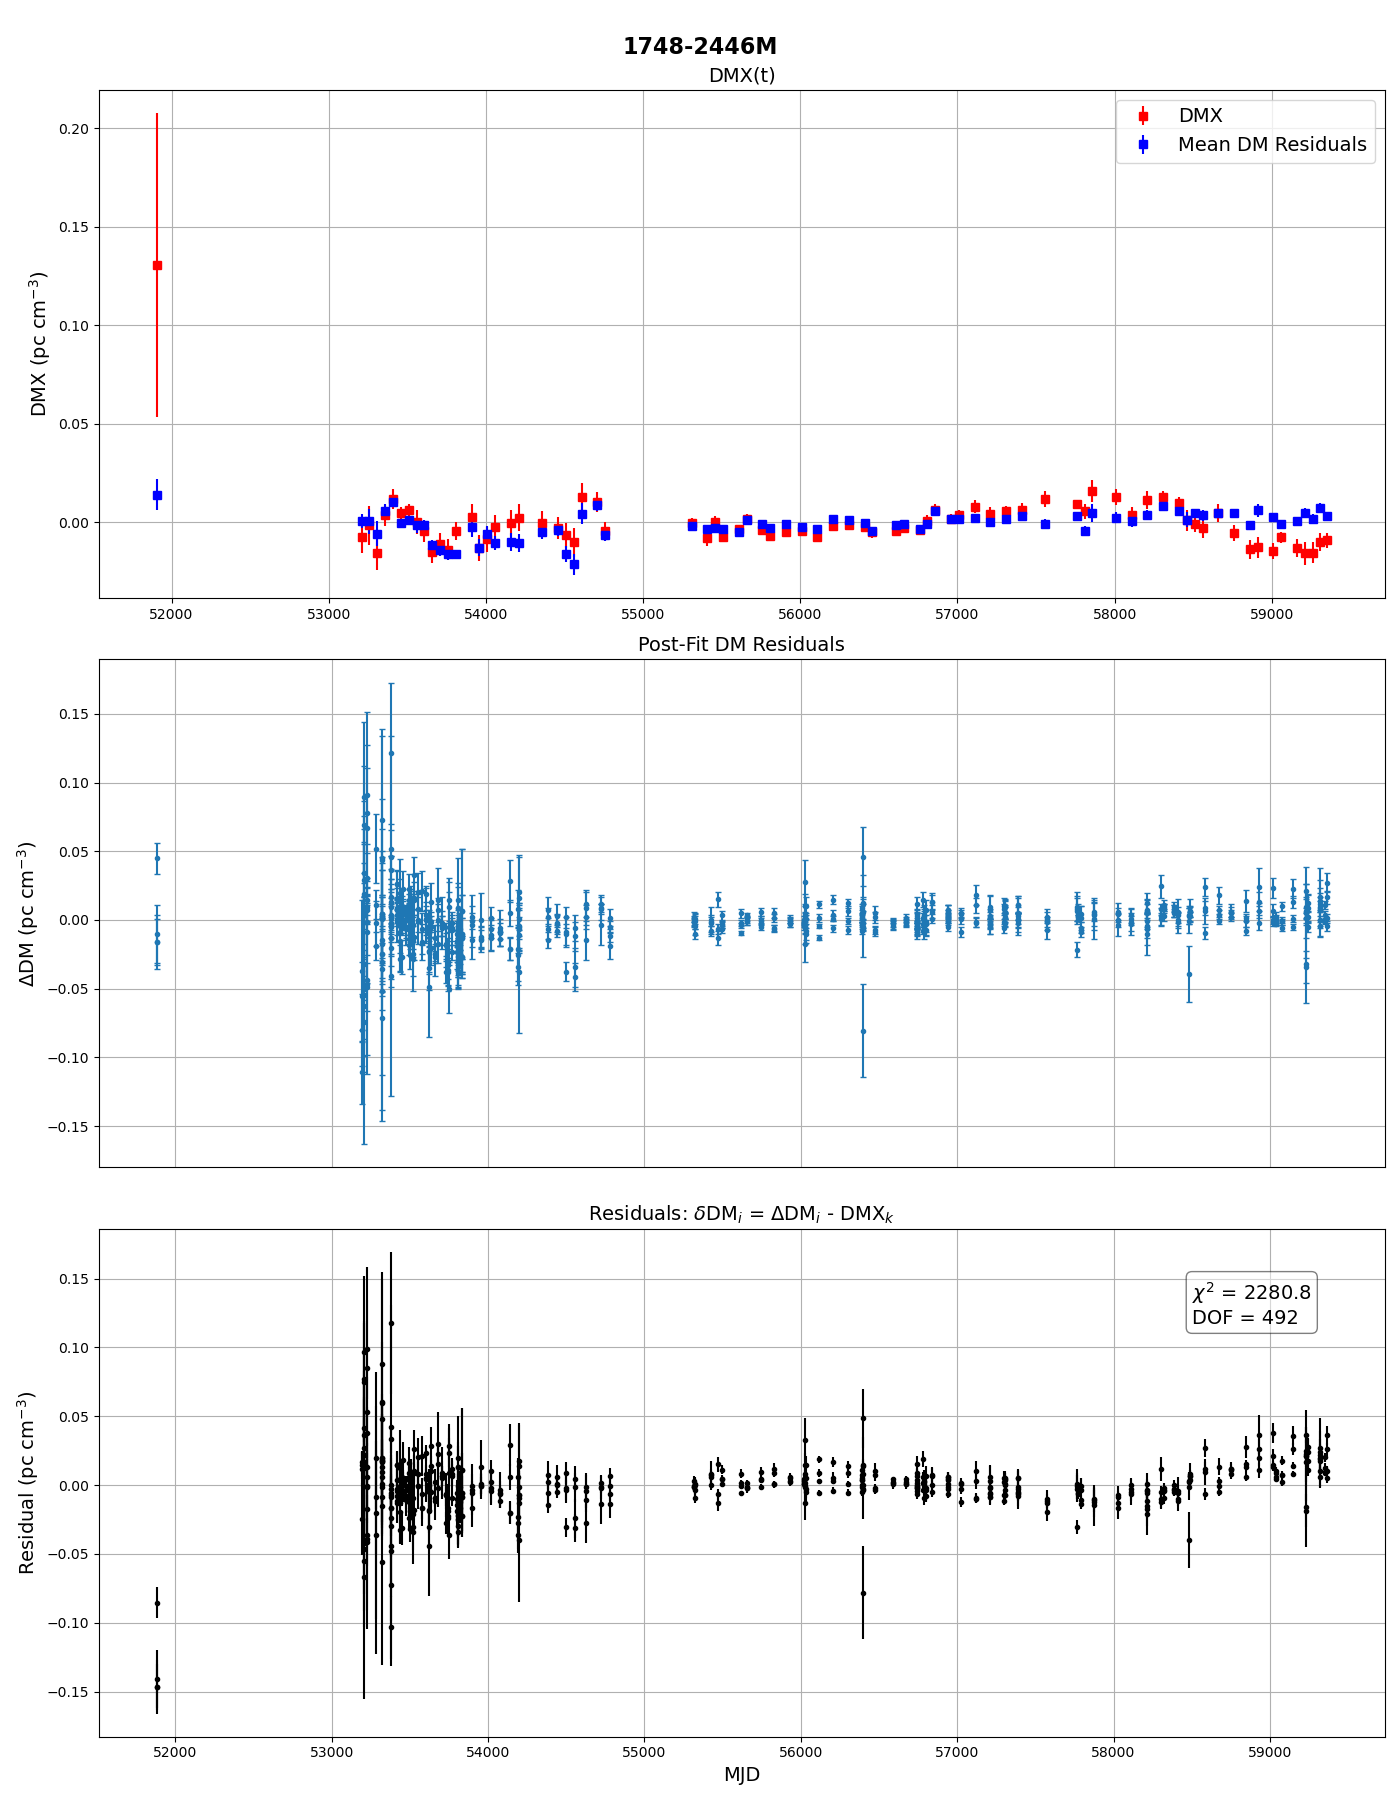

In [6]:
# Plotting

fig, ax = plt.subplots(nrows=3, figsize=(14, 18))

# Panel 1: DMX vs Weighted Mean Residuals                                                                                      
ax[0].errorbar(dmx["dmxeps"], dmx["dmxs"], yerr=dmx["dmx_verrs"], fmt="s", color="red", label="DMX")
ax[0].errorbar(dmx["dmxeps"], weighted_means, yerr=weighted_errs, fmt="s", color="blue", label="Mean DM Residuals")
ax[0].set_title("DMX(t)", fontsize=14)
ax[0].set_ylabel("DMX (pc cm$^{-3}$)", fontsize=14)
ax[0].grid(True)
ax[0].legend(fontsize=14)

# Panel 2: DM Residuals vs MJD                                                                                                 
ax[1].errorbar(t1.table["mjd_float"], dm_resid, yerr=dm_resid_err, fmt=".", capsize=2)
ax[1].set_title("Post-Fit DM Residuals", fontsize=14)
ax[1].set_ylabel("$\Delta$DM (pc cm$^{-3}$)", fontsize=14)
ax[1].tick_params(axis='x', bottom=False, labelbottom=False)
ax[1].grid(True)

# Panel 3: Corrected residuals                                                                                                 
ax[2].errorbar(t1.get_mjds().value, dm_resid_corrected_flat, yerr=dm_resid_err_flat, fmt=".", color="black")
ax[2].set_title("Residuals: $\delta$DM$_i$ = $\Delta$DM$_i$ - DMX$_k$", fontsize=14)
ax[2].set_xlabel("MJD", fontsize=14)
ax[2].set_ylabel("Residual (pc cm$^{-3}$)", fontsize=14)
ax[2].text(0.85, 0.90, f"$\chi^2$ = {chi2:.1f}\nDOF = {dof}", transform=ax[2].transAxes,
           fontsize=14, va="top", bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))
ax[2].grid(True)

fig.suptitle(f"{m1.PSR.value}", fontsize=16, fontweight="bold")
fig.tight_layout()
plt.subplots_adjust(top=0.95)
plt.savefig(f"{m1.PSR.value}_residuals_combined_DM1DM2.pdf", dpi=300)
plt.show()

## Common DM + Gaussian Process (GP)

First we extract the common DM over all pulsars:

This section computes the mean DM residuals over all pulsars using PINT by fitting a DMX model for each pulsar, it then calculates the DM residuals per DMX bin <i>k</i>, and then obtaining the weighted mean. Both the data and the plot are generated. The process is performed within a loop for efficiency and simplicity.

In [7]:
from functools import reduce
from scipy import stats

In [8]:
# Loading the par and tim files

pars = ["1748-2446C.par", "1748-2446O.par", "1748-2446E.par", "1748-2446N.par", "1748-2446M.par"]
tims = ["new_Ter5C.tim", "new_Ter5O.tim", "new_Ter5E.tim", "new_Ter5N.tim", "new_Ter5M.tim"]
colors = ['b', 'g', 'r', 'c', 'm']

In [9]:
# Helper functions

def weighted_avg(values, errors):
    mask = ~np.isnan(values) & ~np.isnan(errors)
    if np.any(mask):
        weights = 1 / np.square(errors[mask])
        return np.sum(values[mask] * weights) / np.sum(weights)
    return np.nan

def weighted_avg_error(errors):
    mask = ~np.isnan(errors)
    if np.any(mask):
        weights = 1 / np.square(errors[mask])
        return np.sqrt(1 / np.sum(weights))
    return np.nan

def compute_dmx_bins(allmjds, span_days=50):
    mjd_min, mjd_max = np.min(allmjds), np.max(allmjds)
    start_mjds = np.arange(mjd_min, mjd_max, span_days)
    end_mjds = np.minimum(start_mjds + span_days, mjd_max)
    valid = [(s, e) for s, e in zip(start_mjds, end_mjds) if np.any((allmjds >= s) & (allmjds < e))]
    return np.array([v[0] for v in valid]), np.array([v[1] for v in valid])

def compute_dm_residuals(t1, m1):
    residuals = pint.residuals.Residuals(t1, m1)
    time_resids = residuals.calc_time_resids().value
    freqs = t1.table['freq'].data
    errors = t1.table['error'].value * 1e-6
    dm_resid = (time_resids * freqs**2) / 4.15e3
    dm_resid_err = (errors * freqs**2) / 4.15e3
    return dm_resid, dm_resid_err

def process_pulsar(par_file, tim_file, color):
    model, toas = get_model_and_toas(par_file, tim_file, usepickle=True)

    # Freeze all parameters except DM                                                                                          
    #for param in model.free_params:
    #    if param != "DM":
    #        getattr(model, param).frozen = False

    allmjds = toas.get_mjds().value
    start_mjds, end_mjds = compute_dmx_bins(allmjds, bin_width)

    # Remove existing DMX parameters and add new component                                                                     
    for param in list(model.params):
        if param.startswith("DMX"):
                model.remove_param(param)

    dmx_model = pint.models.dispersion_model.DispersionDMX()
    dmx_model.DMXR1_0001.value = start_mjds[0]
    dmx_model.DMXR2_0001.value = end_mjds[0]
    dmx_model.add_DMX_ranges(start_mjds[1:], end_mjds[1:], dmxs=0, frozens=False)
    model.add_component(dmx_model)

    # Fit and extract DMX results                                                                                              
    fitter = pint.fitter.WLSFitter(toas, model)
    fitter.fit_toas(maxiter=1)
    dmx_result = pint.utils.dmxparse(fitter)

    dm_resid, dm_resid_err = compute_dm_residuals(toas, model)
    means, errors = [], []

    for r1, r2 in zip(dmx_result["r1s"], dmx_result["r2s"]):
        mask = (toas.table['mjd_float'] >= r1) & (toas.table['mjd_float'] <= r2)
        resid_bin = dm_resid[mask]
        err_bin = dm_resid_err[mask]        
        if len(resid_bin) > 0:
            weights = 1 / err_bin**2
            mean = np.sum(resid_bin * weights) / np.sum(weights)
            err = np.sqrt(1 / np.sum(weights))
            means.append(mean)
            errors.append(err)

    return {
        "name": model.PSR.value,
        "epochs": dmx_result["dmxeps"],
        "dmx_means": np.array(means),
    	"dmx_errors": np.array(errors),
        "color": color
    }
        

In [10]:
# Main loop

results = []
for par, tim, color in zip(pars, tims, colors):
    print(f"Processing {par} and {tim}")
    result = process_pulsar(par, tim, color)
    results.append(result)

# Align and stack data                                                                                                         
dmx_epochs = np.array([r["epochs"] for r in results])
dmx_means = np.array([r["dmx_means"] for r in results])
dmx_errors = np.array([r["dmx_errors"] for r in results])
bin_centers = np.mean(dmx_epochs, axis=0)

binned_means = [weighted_avg(dmx_means[:, i], dmx_errors[:, i]) for i in range(dmx_means.shape[1])]
binned_errors = [weighted_avg_error(dmx_errors[:, i]) for i in range(dmx_errors.shape[1])]

INFO     (pint.toa                      ): Reading TOAs from the picklefile for `new_Ter5C.tim`


Processing 1748-2446C.par and new_Ter5C.tim


WARNING  (pint.logging                  ): /home/uwm/vleescho/Data15/vleescho/conda/envs/IPTA_Env/lib/python3.9/site-packages/pint/fitter.py:2050 DegeneracyWarning: Parameter degeneracy; the following linear combination yields almost no change: 0.2177993505815333*DMX_0040 + 0.20352729196319266*DMX_0048 + 0.19868062686867272*DMX_0031 + 0.197847186577691*DMX_0036 + 0.19364032364877184*DMX_0034 + 0.17858846368161793*DMX_0035 + 0.1731489201473092*DMX_0043 + 0.17254436093180497*DMX_0037 + 0.17099267013667643*DMX_0032 + 0.16927751628413612*DMX_0045 + 0.16734961977792515*DMX_0014 + 0.16616356212576447*DMX_0033 + 0.1602047355655365*DMX_0052 + 0.1564743287244808*DMX_0042 + 0.15333165118499426*DMX_0044 + 0.15234883054764187*DMX_0028 + 0.15171398460997707*DMX_0030 + 0.15132836858570564*DMX_0071 + 0.14875754798239288*DMX_0049 + 0.14659843366812225*DMX_0041 + 0.14333458127743803*DMX_0039 + 0.14278247518740925*DMX_0055 + 0.14213797177796286*DMX_0007 + 0.14160474891283834*DMX_0061 + 0.140075271681561

Processing 1748-2446O.par and new_Ter5O.tim


WARNING  (pint.logging                  ): /home/uwm/vleescho/Data15/vleescho/conda/envs/IPTA_Env/lib/python3.9/site-packages/pint/fitter.py:2050 DegeneracyWarning: Parameter degeneracy; the following linear combination yields almost no change: 1.0*DM + 2.8456003775163558e-11*F10 + 2.0574397837874347e-11*F7 + -1.2468607801815606e-11*F8 + -1.5039631616887536e-11*F11 + -1.6725325809097423e-11*F9 + -0.013253199858741804*DMX_0016 + -0.014100564772454931*DMX_0019 + -0.015013634785816521*DMX_0017 + -0.015428757066254718*DMX_0015 + -0.016249313596621153*DMX_0018 + -0.016322285518788705*DMX_0006 + -0.016374529440720636*DMX_0003 + -0.017606209771277585*DMX_0012 + -0.018333093656334478*DMX_0001 + -0.01972704647174067*DMX_0020 + -0.02007154604998696*DMX_0004 + -0.020224316438483724*DMX_0009 + -0.02095303507902183*DMX_0005 + -0.023247426047614168*DMX_0013 + -0.023259371960633973*DMX_0010 + -0.024573082452096176*DMX_0011 + -0.02876464363510614*DMX_0002 + -0.031400625291881486*DMX_0027 + -0.03317086

Processing 1748-2446E.par and new_Ter5E.tim


WARNING  (pint.logging                  ): /home/uwm/vleescho/Data15/vleescho/conda/envs/IPTA_Env/lib/python3.9/site-packages/pint/fitter.py:2050 DegeneracyWarning: Parameter degeneracy; the following linear combination yields almost no change: 0.23310113549562267*DMX_0061 + 0.2153452170645604*DMX_0032 + 0.21212199812062882*DMX_0041 + 0.2098426223397237*DMX_0037 + 0.20931262941798515*DMX_0045 + 0.20686929159157508*DMX_0034 + 0.19683586497393155*DMX_0043 + 0.19660511585753607*DMX_0038 + 0.19222790669685202*DMX_0071 + 0.18564195687949595*DMX_0047 + 0.18025153297662477*DMX_0039 + 0.17989724091123005*DMX_0062 + 0.17783663791205173*DMX_0028 + 0.17294365305926265*DMX_0044 + 0.1699265701681874*DMX_0048 + 0.16790216868284005*DMX_0055 + 0.1645902798112992*DMX_0040 + 0.1580743757498735*DMX_0052 + 0.1544475782054493*DMX_0076 + 0.14933157775932876*DMX_0033 + 0.1492580611968119*DMX_0036 + 0.14816500258303128*DMX_0035 + 0.13416931797500642*DMX_0031 + 0.13224842147581087*DMX_0030 + 0.1165351487399735

Processing 1748-2446N.par and new_Ter5N.tim


WARNING  (pint.logging                  ): /home/uwm/vleescho/Data15/vleescho/conda/envs/IPTA_Env/lib/python3.9/site-packages/pint/fitter.py:2050 DegeneracyWarning: Parameter degeneracy; the following linear combination yields almost no change: 0.271622906166785*DMX_0048 + 0.2168072195175172*DMX_0034 + 0.20987666404559974*DMX_0035 + 0.20341377560374854*DMX_0071 + 0.1978569302824672*DMX_0061 + 0.19606757906588052*DMX_0045 + 0.18792133081646356*DMX_0055 + 0.1851879588285571*DMX_0076 + 0.17355415189004528*DMX_0033 + 0.17075252332304644*DMX_0036 + 0.16599677796989412*DMX_0038 + 0.1641773002686111*DMX_0039 + 0.15374027060749354*DMX_0041 + 0.15011717596234453*DMX_0028 + 0.14523395440144313*DMX_0062 + 0.14307020150875482*DMX_0037 + 0.14274407066228628*DMX_0043 + 0.14186720736436778*DMX_0070 + 0.14041735420680015*DMX_0067 + 0.13991460116801052*DMX_0049 + 0.13872823607102502*DMX_0052 + 0.13828108079337056*DMX_0031 + 0.13592472927219382*DMX_0032 + 0.12715846982638232*DMX_0072 + 0.124373113445769

Processing 1748-2446M.par and new_Ter5M.tim


WARNING  (pint.logging                  ): /home/uwm/vleescho/Data15/vleescho/conda/envs/IPTA_Env/lib/python3.9/site-packages/pint/fitter.py:2050 DegeneracyWarning: Parameter degeneracy; the following linear combination yields almost no change: 1.0*DM + -0.024586666801100474*DMX_0001 + -0.02969191473402231*DMX_0003 + -0.030211749887697877*DMX_0004 + -0.03577153437491506*DMX_0024 + -0.03666712545641617*DMX_0015 + -0.03691652312939636*DMX_0025 + -0.04122440322584631*DMX_0019 + -0.04238849701603504*DMX_0020 + -0.04306512671222066*DMX_0057 + -0.043813728197979344*DMX_0016 + -0.04707121604097684*DMX_0017 + -0.048402756846290515*DMX_0023 + -0.04967697958545265*DMX_0009 + -0.05040493394711745*DMX_0063 + -0.05329976370698408*DMX_0021 + -0.05540414719655454*DMX_0018 + -0.05544523659263707*DMX_0002 + -0.05800827121975144*DMX_0012 + -0.05863881418588174*DMX_0005 + -0.05890630410823964*DMX_0069 + -0.06377654600758867*DMX_0022 + -0.06723771608235862*DMX_0013 + -0.06789865818527296*DMX_0027 + -0.068

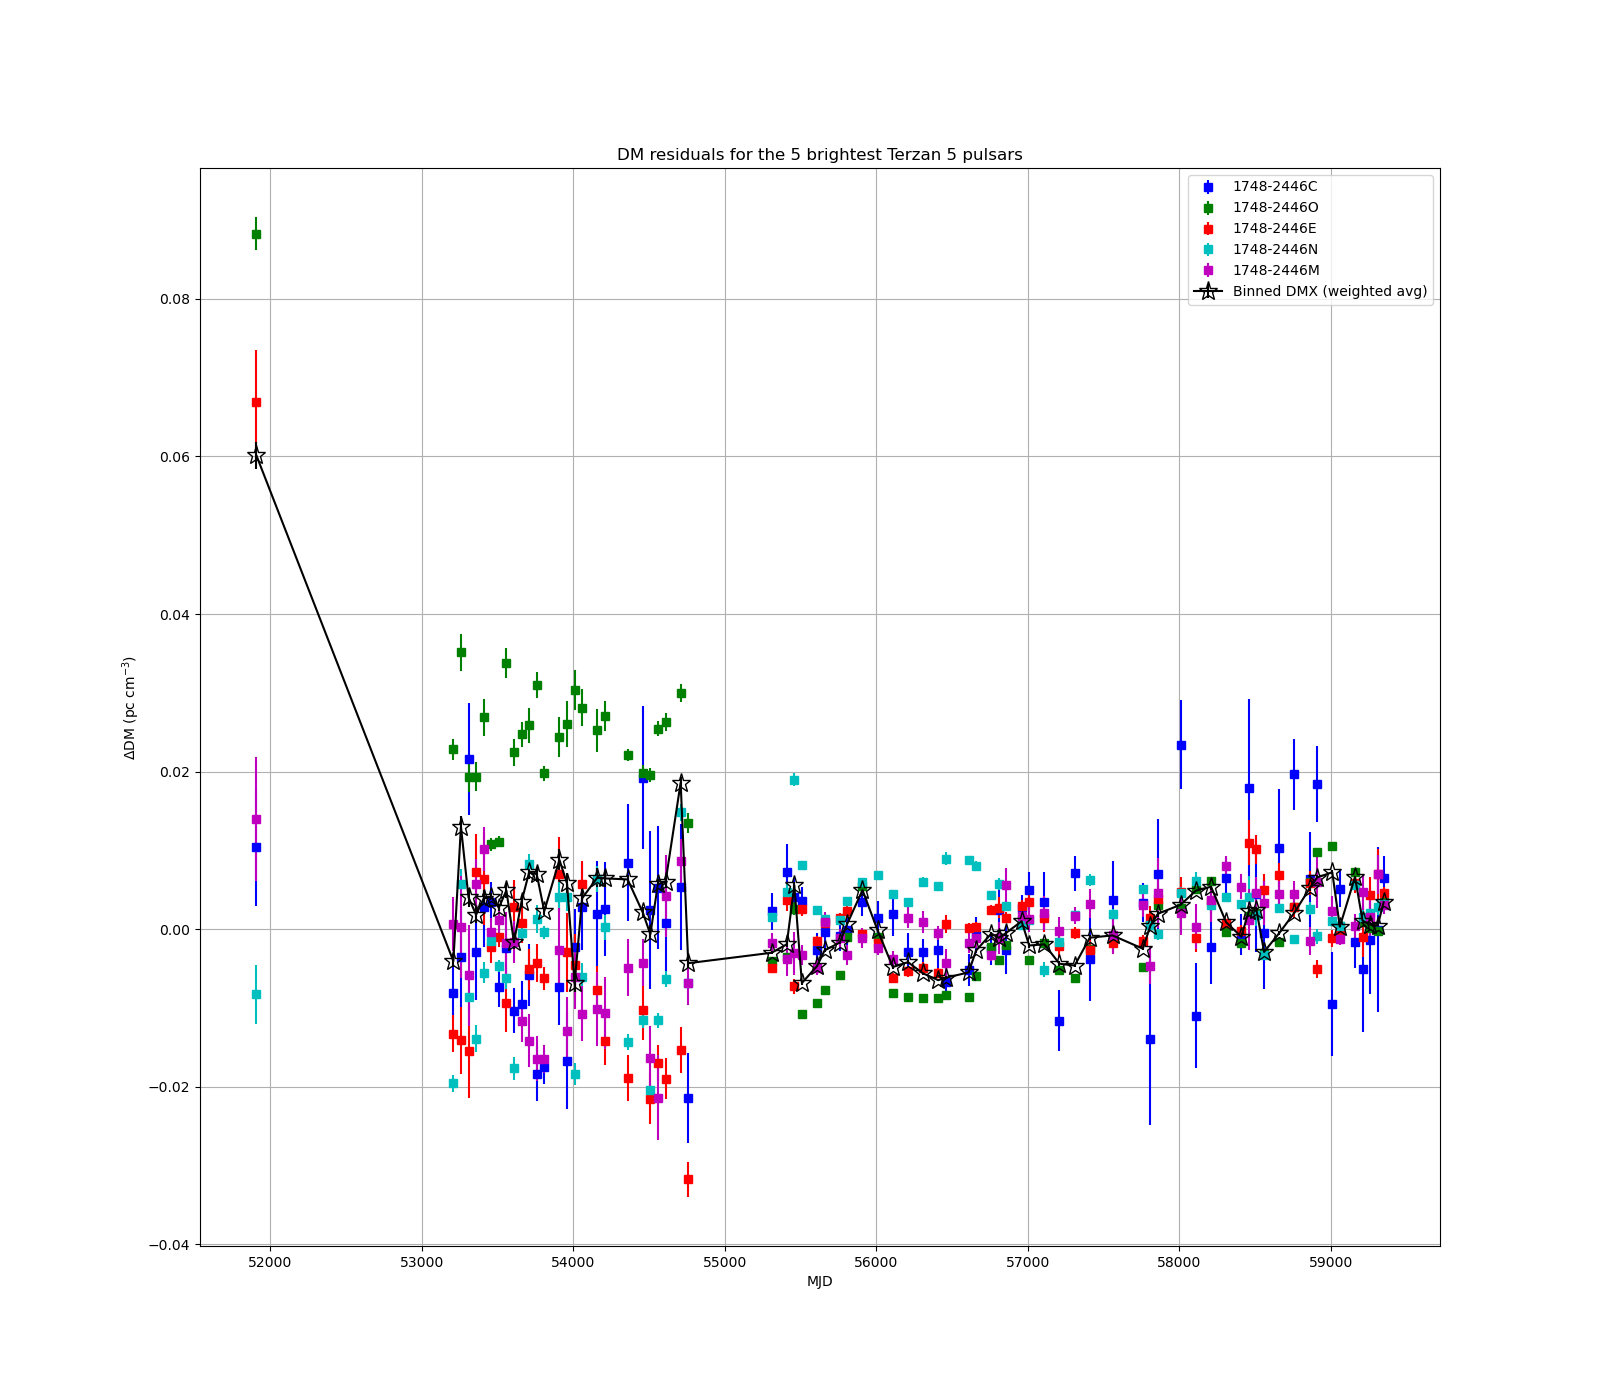

In [11]:
# Save results

np.savetxt("meanDMresid_data_5psrs_DM1DM2.txt",
           np.column_stack([bin_centers, binned_means, binned_errors]),
           header="Bin_MJD, Avg_DMX, Avg_Error", fmt="%.6f")

#Plotting

fig, ax = plt.subplots(figsize=(16, 14))

for res in results:
    ax.errorbar(res["epochs"], res["dmx_means"], yerr=res["dmx_errors"], fmt='s',
                color=res["color"], label=res["name"])

ax.errorbar(bin_centers, binned_means, yerr=binned_errors, marker="*", linestyle='-', color = 'black',
            markeredgecolor='black', markerfacecolor='None', markersize=14,
            label="Binned DMX (weighted avg)")

ax.set_xlabel("MJD")
ax.set_ylabel(r"$\Delta$DM (pc cm$^{-3}$)")
ax.set_title("DM residuals for the 5 brightest Terzan 5 pulsars")
ax.legend()
ax.grid(True)

plt.savefig("DM_residuals_all_pulsars_newv.png", dpi=300, bbox_inches="tight")
plt.show()

Secondly, we use the results of the common DM to subract it from the DM residuals of each pulsar, and then fit a Gaussian Process Regression (GPR) kernel to each pulsar individually. This is done separately for each pulsar, as the optimal kernel may differ between them. 

In [12]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, RationalQuadratic

In [13]:
# Load the average DM values

data = np.genfromtxt('meanDMresid_data_5psrs_DM1DM2.txt', names=True, dtype=None, encoding=None)
avg_dm = data['Avg_DMX']
avg_err = data['Avg_Error']

In [14]:
# Compute DM residuals

# Iterate over each DM bin and subtract the corresponding mean DM value                                                        
dmresid_perbin_meanDM = []
for i, bin_dm_resid in enumerate(dm_resid_perbin):
    if len(bin_dm_resid) > 0:
        # Subtract the corresponding mean dm value from each element in the bin                                                
        subtracted_bin = bin_dm_resid - avg_dm[i]
        dmresid_perbin_meanDM.append(subtracted_bin)
    else:
        # If the bin is empty, append an empty array                                                                           
        dmresid_perbin_meanDM.append(np.array([]))

dmresid_perbin_meanDM_flat = np.concatenate(dmresid_perbin_meanDM)

In [15]:
# Fitting the GP Regression to the data

X = t1.get_mjds().value[:, np.newaxis]
y = dmresid_perbin_meanDM_flat[:, np.newaxis]
kernel = (1.0 * RBF(length_scale=500) +
          1.0 * RationalQuadratic(length_scale=50, alpha=1.0) +
          1.0 * Matern(length_scale=20, nu=0.5) +
          WhiteKernel(noise_level=1))

gp = GaussianProcessRegressor(kernel=kernel, alpha=dm_resid_err**2, n_restarts_optimizer=10)
gp.fit(X, y)
X_pred = np.linspace(X.min(), X.max(), 500)[:, np.newaxis]
y_pred, sigma = gp.predict(X_pred, return_std=True)

# Chi-squared                                                                                                                  
residuals_norm = (y.flatten() - gp.predict(X).flatten()) / dm_resid_err
chi2 = np.sum(residuals_norm**2)
dof = len(y) - len(kernel.theta)
chi2_red = chi2 / dof

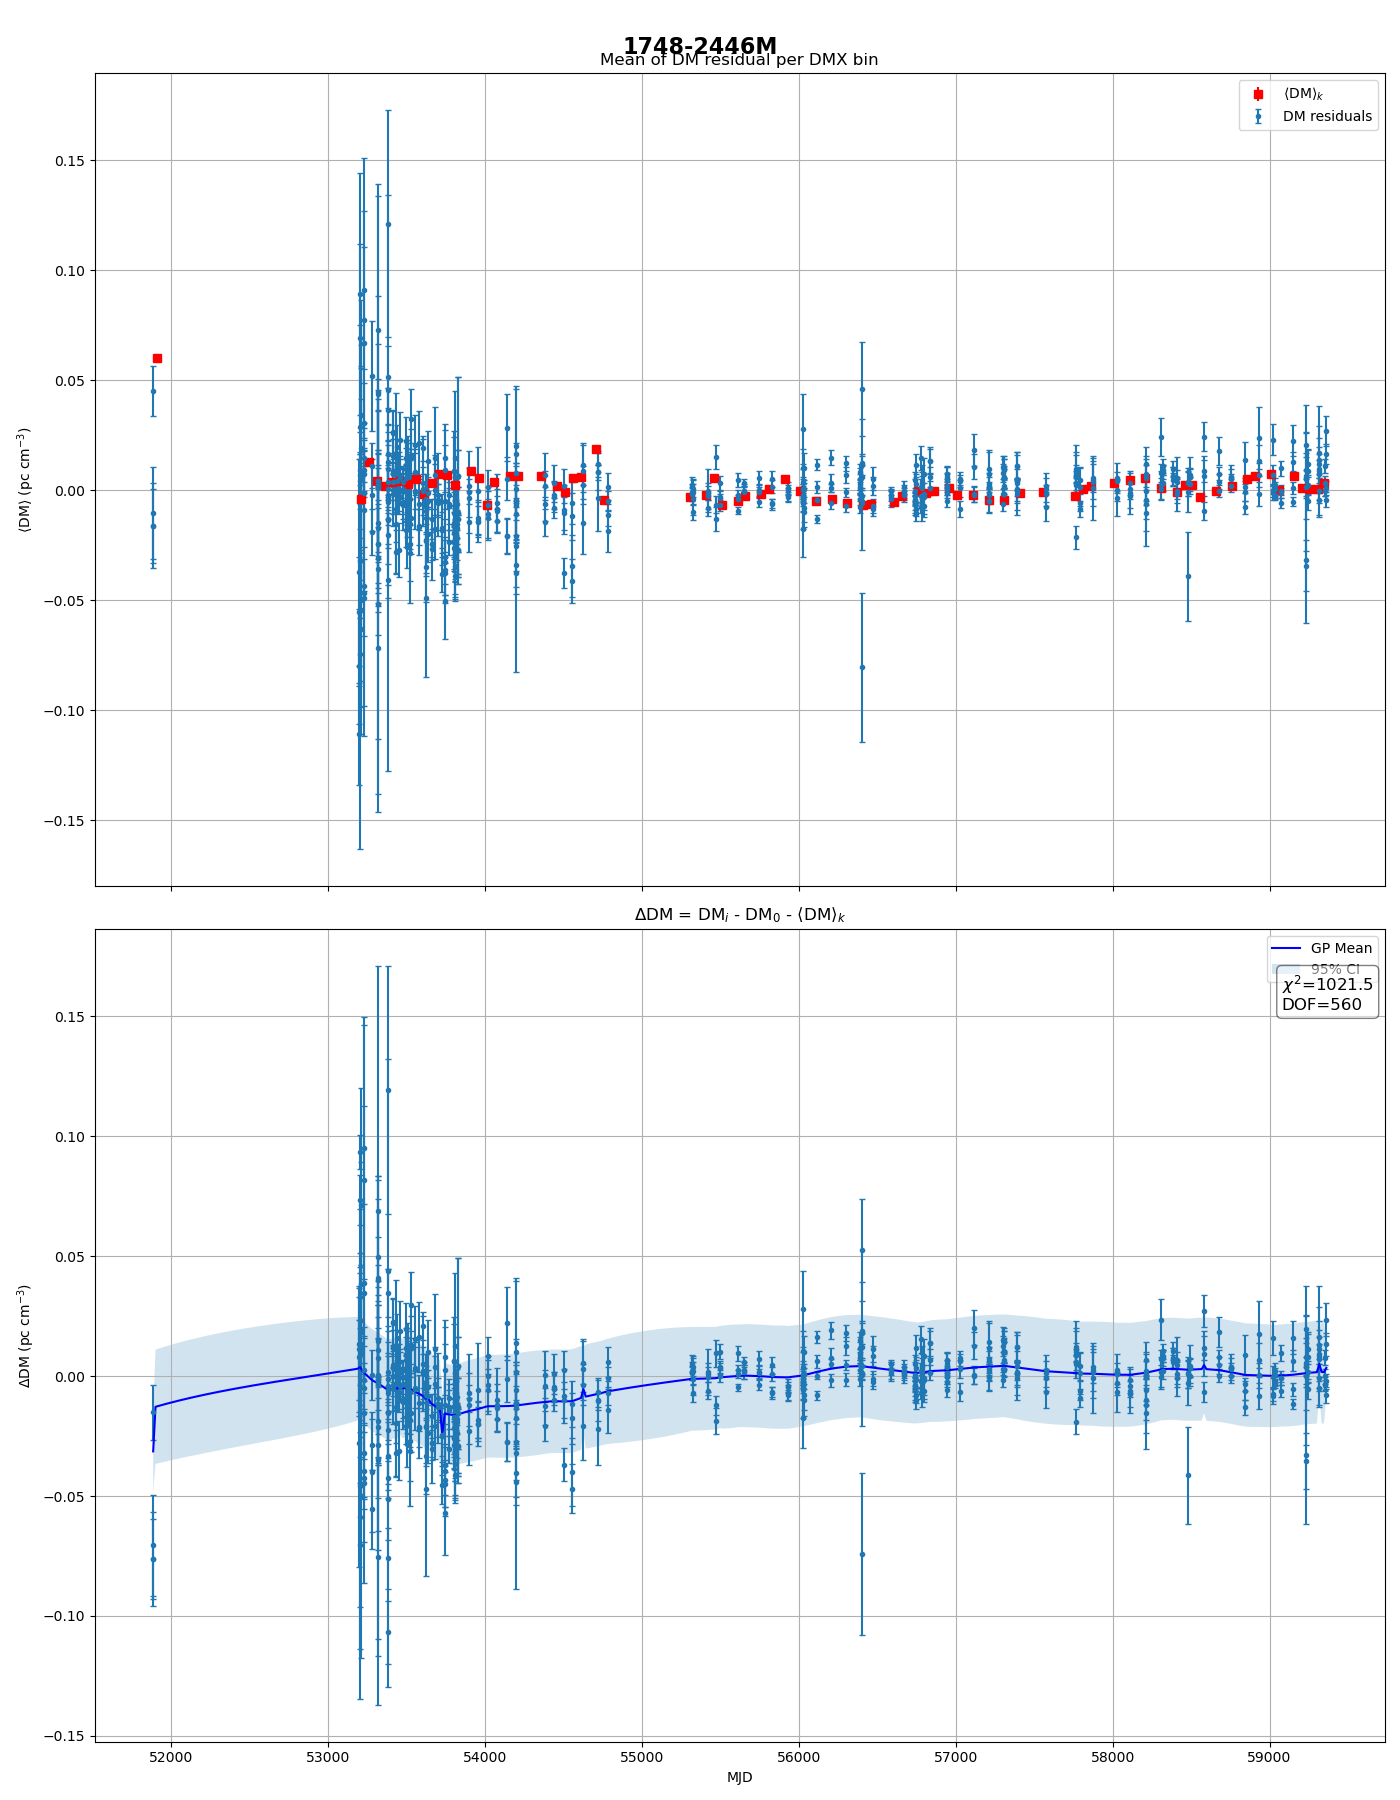

In [16]:
# Plotting

fig, ax = plt.subplots(2, 1, figsize=(14, 18))

# Top panel: Avg DM and Residuals                                                                                              
ax[0].errorbar(dmx["dmxeps"], avg_dm, yerr=avg_err, fmt="s", color="red", label=r"$\langle\mathrm{DM}\rangle_k$")
ax[0].errorbar(t1.table['mjd_float'], dm_resid, yerr=dm_resid_err, fmt=".", capsize=2, label="DM residuals")
ax[0].legend(loc="upper right")
ax[0].set_title("Mean of DM residual per DMX bin")
ax[0].set_ylabel(r"$\langle$DM$\rangle$ (pc cm$^{-3}$)")
ax[0].grid(True)
ax[0].tick_params(labelbottom=False)

# Bottom panel: Residuals minus mean                                                                                           
ax[1].errorbar(t1.get_mjds().value, dmresid_perbin_meanDM_flat, yerr=dm_resid_err, fmt=".", capsize=2)
ax[1].plot(X_pred, y_pred, color='blue', label='GP Mean')
ax[1].fill_between(X_pred.ravel(), y_pred.ravel() - 1.96 * sigma,
                   y_pred.ravel() + 1.96 * sigma, alpha=0.2, label='95% CI')
ax[1].legend()
ax[1].set_xlabel("MJD")
ax[1].set_ylabel(r"$\Delta$DM (pc cm$^{-3}$)")
ax[1].set_title(r"$\Delta$DM = DM$_i$ - DM$_0$ - $\langle$DM$\rangle_k$")
ax[1].grid(True)
ax[1].figure.text(0.92, 0.90, f"$\\chi^2$={chi2:.1f}\nDOF={dof}", transform=ax[1].transAxes,
                  fontsize=12, bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))

fig.suptitle(f"{m1.PSR.value}", fontsize=16, fontweight="bold")
fig.tight_layout()
plt.savefig(f"{m1.PSR.value}_meanDMresid_combined_plall_test.png", dpi=300, bbox_inches="tight")
plt.show()